# Phylogenetically informed MSA-transformers

A set of function were defined in `phylo_msa.py` to perform the following task;

In [2]:
import pandas as pd
import numpy as np
import ete3
import tarfile
import matplotlib.pyplot as plt
import seaborn as sns
import re
import phylo_msa
from Bio import AlignIO
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio.SeqIO.FastaIO import FastaWriter

data_dir = 'data'
tree_archive = f'{data_dir}/Tree.tar.gz'
msa_archive = f'{data_dir}/MSAs.tar.gz'

In [3]:
# Get studied proteins names
# Get proteins names from the phylo tree archive
tree_archive = 'data/Tree.tar.gz'
pattern = r'Tree/(\S+)_pruned.tre'
tree_proteins = [re.search(pattern, tree).group(1) for tree in tarfile.open(tree_archive).getnames() if "/" in tree]

# Get proteins names from the MSA archive
msa_archive = "data/MSAs.tar.gz"
pattern = r"MSAs/(\S+)"
msa_proteins = [re.search(pattern, msa).group(1) for msa in tarfile.open(msa_archive).getnames() if "/" in msa]

# Get proteins names with MSA and tree
proteins = set(tree_proteins) & set(msa_proteins)

print(f"Proteins with MSA and tree: {len(proteins)}")

Proteins with MSA and tree: 16761


In [4]:
# Stats on MSAs and query human proteins

pattern_id = r"sp\|([^|]+)\|"
pattern_desc = r"_HUMAN\s+(.*)"

msa_data = {'average': 0,'min':0, 'max':0}
human_proteins = []
sequences_count = []
msa_depth = {}

for msa in proteins:
    with open(f'{data_dir}/MSAs/{msa}') as f:
        msa = AlignIO.read(f, 'fasta')

        # Get data on the human proteins
        id_protein = re.search(pattern_id, msa[0].id).group(1)
        description = re.search(pattern_desc, msa[0].description).group(1)
        human_proteins.append({'id':id_protein,'description': description})

        # Get sequences count
        msa_depth[id_protein] = len(msa)

        sequences_count.append(len(msa))

# Get min and max
msa_data['min'] = min(sequences_count)
msa_data['max'] = max(sequences_count)
# Get average
msa_data['average'] = np.mean(sequences_count)

print(f"Average sequences count: {msa_data['average']}")
print(f"Min sequences count: {msa_data['min']}")
print(f"Max sequences count: {msa_data['max']}")

pd.DataFrame(human_proteins).to_csv('results/human_proteins.csv')


Average sequences count: 817.467812183044
Min sequences count: 8
Max sequences count: 5001


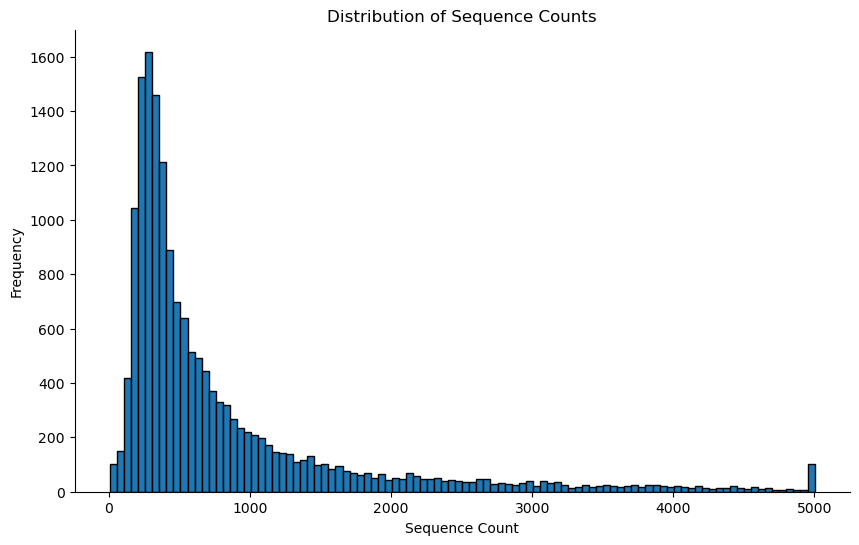

In [5]:
# Plot distribution of sequences count
plt.figure(figsize=(10, 6))
# Create a histogram
plt.hist(sequences_count, bins=100, edgecolor='black')

plt.title('Distribution of Sequence Counts')
plt.xlabel('Sequence Count')
plt.ylabel('Frequency')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.show()

An outlier is seen, a MSA with 5,000 sequences matching the query. It reflects the upper limit of matches inherent to the MSA computing process, which affected the results of several queries.

In [7]:
# Print proteins with maximum sequences count
max_match = []
for key, count in msa_depth.items():
    if count == msa_data['max']:
            max_match.append(key)

print(f"For the folowing {len(max_match)} proteins, the maximum amount of matching sequences ({msa_data['max']-1}) was found.")
for protein in max_match:
    print(f"- {protein}")

For the folowing 67 proteins, the maximum amount of matching sequences (5000) was found.
- Q96R67
- Q8NGD1
- Q96R09
- Q8NGD5
- Q8NH85
- O95013
- Q8NG99
- Q96RA2
- Q8NGL0
- Q8NH10
- Q8NGL6
- Q9GZM6
- Q8NGN0
- Q8NH72
- Q8NG95
- O43749
- O76099
- Q15617
- Q8NGQ1
- Q8NGD4
- P58180
- Q8NGA0
- Q8NGP0
- Q8NGL1
- Q8NGF9
- P03915
- Q8NGI6
- Q6IF82
- Q8NH49
- Q8NGJ0
- Q8NG75
- Q8NGI4
- Q8NGM9
- Q8NGP6
- Q6IFN5
- Q8NH05
- O76100
- Q8NH73
- O60412
- Q8NGC6
- Q8NGE8
- A6NHA9
- Q8NGP9
- Q8NH41
- Q8NGF8
- P01911
- Q6IEU7
- Q8NH69
- O14581
- Q8NH43
- Q96R08
- Q15615
- Q6IEV9
- P47890
- Q8IXE1
- Q8NGB4
- Q8NGS2
- Q8WZ84
- P30953
- Q8NGA8
- P10745
- Q8NGA1
- Q8NGD2
- Q8NH42
- Q13606
- Q8NGL2
- O95221


# Selection of mammalia

From Upham et al. tree, we obtain phylogenetic relationship between mammalia. The tree was pruned to only keep species also present in MSAs.

In [8]:
upham_tree = ete3.Tree("data/Tree/upham_tree_cleaned.nw", format=1)
print(upham_tree)
print(len(upham_tree.get_leaves()), "species")


                                                /-Dinomys_branickii
                                               |
                                               |         /-Chinchilla_chinchilla
                                             /-|      /-|
                                            |  |   /-|   \-Chinchilla_lanigera
                                            |  |  |  |
                                            |   \-|   \-Lagidium_viscacia
                                            |     |
                                            |      \-Lagostomus_maximus
                                            |
                                            |               /-Octomys_mimax
                                            |            /-|
                                            |           |  |   /-Pipanacoctomys_aureus
                                            |           |   \-|
                                            |           |     |   /-Tympanoct

Using Treemmer ([Menardo et al., 2018](https://doi.org/10.1186/s12859-018-2164-8)) we reduced the tree to 256 and 128 leaves while preserving as much diversity as possibile.

Scaling down the mammalia tree from 3,186 species identified by Upham et al. AND in the MSAs, by at least a factor 10, is obviously a a big cut.

In [10]:
# Get Treemmer's pruned tree selected species
pruned_tree_256 = ete3.Tree("results/treemmer/upham_tree_cleaned.nw_trimmed_tree_X_256", format=1)
pruned_leaves_256 = [leaf.name for leaf in pruned_tree_256.get_leaves()]
print(pruned_tree_256)

pruned_tree_128 = ete3.Tree("results/treemmer/upham_tree_cleaned.nw_trimmed_tree_X_128", format=1)
pruned_leaves_128 = [leaf.name for leaf in pruned_tree_128.get_leaves()]


                                                /-Dinomys_branickii
                                             /-|
                                            |   \-Lagostomus_maximus
                                          /-|
                                         |  |   /-Abrocoma_bennettii
                                         |  |  |
                                         |   \-|      /-Carterodon_sulcidens
                                       /-|     |   /-|
                                      |  |      \-|   \-Plagiodontia_aedium
                                      |  |        |
                                      |  |         \-Pattonomys_semivillosus
                                    /-|  |
                                   |  |   \-Erethizon_dorsatum
                                   |  |
                                   |  |      /-Myoprocta_acouchy
                                   |  |   /-|
                                   |   \-|   \-Kerodon_

We'll combine Treemmer reduced mammalia set to the 150 most distributed species across the MSAs.

We also ensure that the usual model species are part of the set (i.e.: *Mus musculus*, *Gorilla gorilla*, *Sus domesticus*, *Canis lupus*, etc.)

In [11]:
# Get species present in MSAs (can be long)
species_in_msa = phylo_msa.count_species("data/deduplicated_MSAs")

# Extract the 150 most represented species
species_in_msa_bin = pd.DataFrame(species_in_msa).fillna(0).apply(sum, axis=1)
species_in_msa_bin.sort_values(ascending=False, inplace=True)

top_150_species = species_in_msa_bin.head(150)
top_150_species.index = [sp.replace("/","_").replace(" ","_").capitalize() for sp in top_150_species.index]

In [12]:
# Common species
common_species = list(pd.read_csv("data/common_species.csv")["scientific name"])
common_species = [phylo_msa.standardize_species_name(sp) for sp in common_species]

In [13]:
# Get the final set of species
final_species_256 = set(top_150_species.index) | set(pruned_leaves_256) | set(common_species)
final_species_256 = list(final_species_256)
print(f"1st final set: {len(final_species_256)} species. Including 256 species obtained through Treemer.")

final_species_128 = set(top_150_species.index) | set(pruned_leaves_128) | set(common_species)
final_species_128 = list(final_species_128)
print(f"2nd final set: {len(final_species_128)} species. Including 128 species obtained through Treemer.")

1st final set: 400 species. Including 256 species obtained through Treemer.
2nd final set: 277 species. Including 128 species obtained through Treemer.


In [14]:
# Write selected taxa results
with open(f"results/final_species_{len(final_species_256)}.txt", "w") as f:
    for sp in final_species_256:
        f.write(f"{sp}\n")

with open(f"results/final_species_{len(final_species_128)}.txt", "w") as f:
    for sp in final_species_128:
        f.write(f"{sp}\n")

In [ ]:
# Run to directly get the final_species list
final_species_256 = []
with open(f"results/final_species_400.txt","r") as f:
    for sp in f:
        final_species_256.append(sp.strip())

We can see how despite selecting species that are representative of mammalia diversity, Treemmer introduce lowly represented taxa. A majority appears in few MSAs, while a smaller bunch of species is present in most. We expect this smaller bunch to be composed mostly by species close to Homo sapiens, resulting in overall higher sequences homology to the queried human proteins.

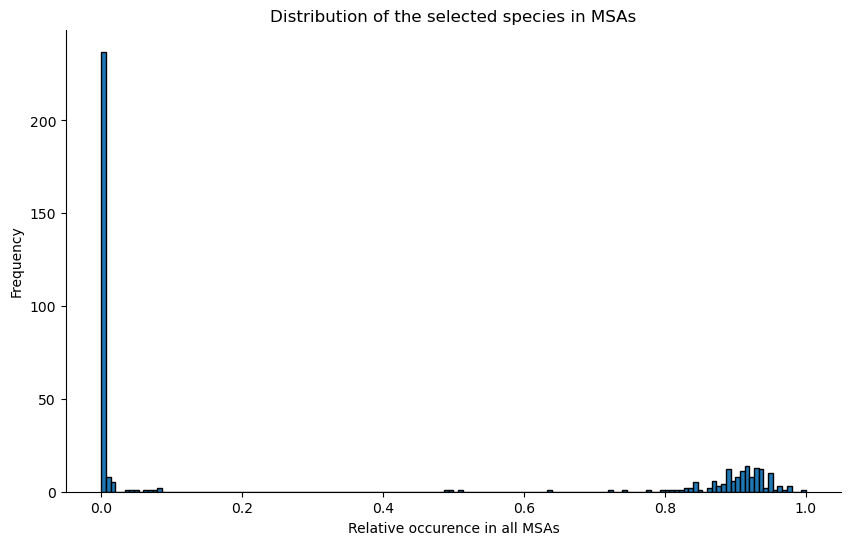

In [ ]:
distribution_final_species_256 = species_in_msa_bin.loc[final_species_256]
distribution_final_species_256 = distribution_final_species_256 / 20366

distribution_final_species_128 = species_in_msa_bin.loc[final_species_128]
distribution_final_species_128 = distribution_final_species_128 / 20366

# Plot distribution of sequences count for the final species set (256 species) and 128 species
plt.figure(figsize=(10, 6))
# Create a histogram
plt.hist(distribution_final_species_256, bins=150, edgecolor='black')

plt.title('Distribution of the selected species in MSAs, including Treemmer\'s 256 species')
plt.xlabel('Relative occurence in all MSAs')
plt.ylabel('Frequency')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.show()

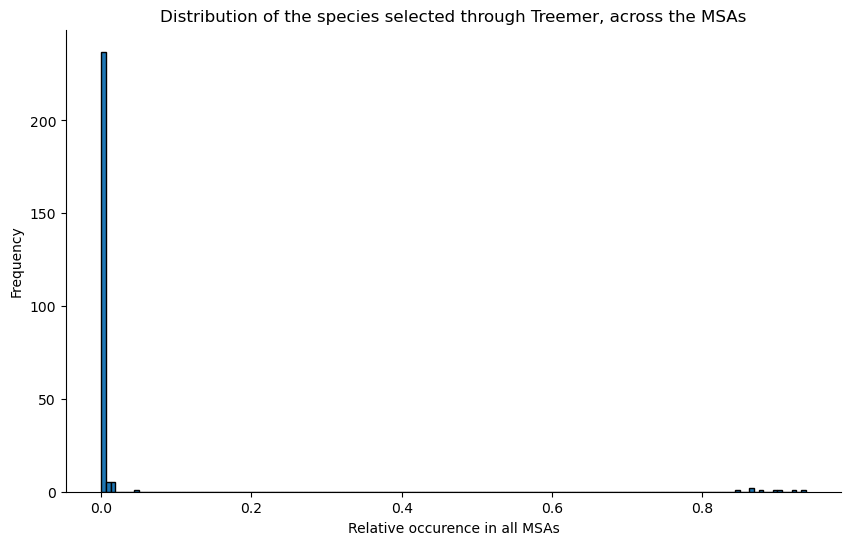

In [ ]:
distribution_treemmer_species = species_in_msa_bin.loc[pruned_leaves_256]
distribution_treemmer_species = distribution_treemmer_species / 20366

# Plot distribution of sequences count
plt.figure(figsize=(10, 6))
# Create a histogram
plt.hist(distribution_treemmer_species, bins=150, edgecolor='black')

plt.title("Distribution of the species selected through Treemer, across the MSAs")
plt.xlabel('Relative occurence in all MSAs')
plt.ylabel('Frequency')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.show()

As we re-write the MSAs, the human query proteins will be the first sequence, followed by the sequences linked to the selected species. If for one of the latter, none of its proteins is among the original matches, we'll replace it by Xs.  
This approach introduce the concept of phylogenetically aware MSAs completude. We expect that a good part of the MSAs is made of Xs sequences.

In [ ]:
# Get the final set of species distribution
species_in_msa_final = pd.DataFrame(species_in_msa).fillna(0).loc[final_species_256]

# Compute the relative species-wise completude in the MSAs
species_in_msa_final_completude = species_in_msa_final.apply(sum, axis=0)
species_in_msa_final_completude = (species_in_msa_final_completude / len(final_species_256)) * 100

NameError: name 'species_in_msa' is not defined

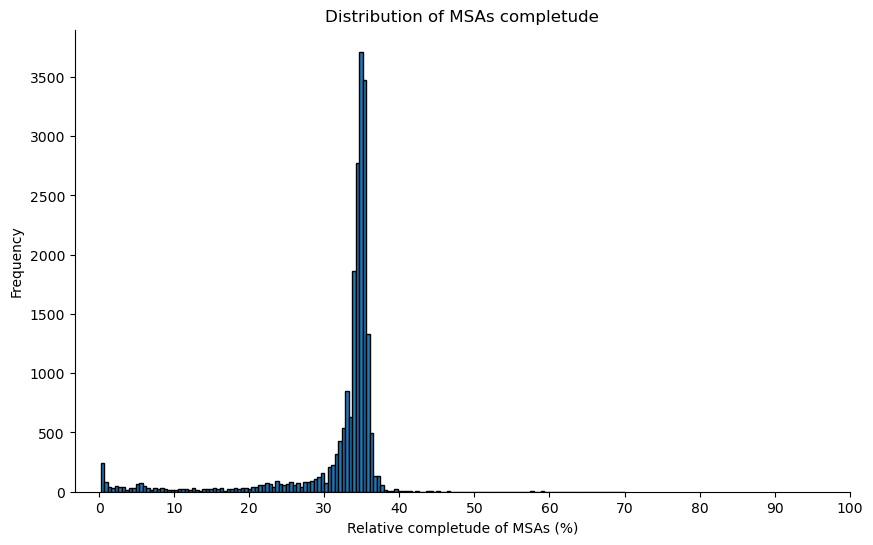

In [21]:
# Plot distribution of sequences count
plt.figure(figsize=(10, 6))
# Create a histogram
plt.hist(species_in_msa_final_completude, bins=150, edgecolor='black')

plt.title('Distribution of MSAs completude')
plt.xlabel('Relative completude of MSAs (%)')
plt.ylabel('Frequency')

plt.xticks(np.arange(0, 101, 10))

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.show()

In [22]:
mean_completude = np.mean(species_in_msa_final_completude)
print(f"Mean completude: {mean_completude}")

Mean completude: 31.95223657075518


**Now we re-order the MSAs.**

The first record is the query, or *Homo sapiens* protein, and the following are sorted according to their growing phylogenetic distance to *Homo sapiens*. We'll use Upham et al. phylogenetic tree to compute those distances. When no proteins is associated to a taxa of the list, we use Xs instead.

In [ ]:
# Compute the list of species according to their increasing phylogenetic distance to Homo sapiens
ordered_species = phylo_msa.phylogenetically_ordered_species("data/Tree/upham_tree_cleaned.nw", species_list=final_species_256)

Now we'll re-order the MSAs.
We'll use the ID the human query protein as the name of each alignment.

It can be long.

In [7]:
phylo_msa.reorder_msa("data/deduplicated_MSAs","data/ordered_MSAs",ordered_species, pattern_id=r"sp\|([^|]+)\|")

# **Structural overview of the sequences**

While we know that our dataset cover mostly human-related species, we need to explore how much of the associated proteins tri-dimensionnal landscape is explored for the species.

In [29]:
annotations_level3_cath = pd.read_csv("results/CATH_annotation_level3.csv", index_col=0)

In [ ]:
# For each annotation
annotation_to_species = {}
for annotation in annotations_level3_cath.index:
    # Get proteins where this annotation is found (value is 1)
    proteins_with_annotation = annotations_level3_cath.loc[annotation][annotations_level3_cath.loc[annotation] == 1].index.tolist()
    
    # For these proteins, find all species that are present in their MSAs
    species_set = set()
    for protein in proteins_with_annotation:
        # Get species that are present in this protein's MSA
        species_in_protein = species_in_msa_final[protein][species_in_msa_final[protein] == 1].index.tolist()
        # Add these species to the set
        species_set.update(species_in_protein)
    
    # Store the set of species for this annotation
    annotation_to_species[annotation] = species_set

relative_coverage = {}
for keys, values in annotation_to_species.items():
    # Get the number of species for this annotation
    relative_coverage[keys] = len(values) / len(final_species_256)

relative_coverage = pd.Series(relative_coverage)

In [39]:
relative_coverage

{'1.20.5': 0.4775,
 '3.30.40': 0.77,
 '3.30.160': 0.8325,
 '1.10.10': 0.445,
 '1.10.1410': 0.3775,
 '3.30.70': 0.57,
 '1.25.10': 0.6125,
 '3.40.30': 0.385,
 '2.10.60': 0.37,
 '1.10.510': 0.5275,
 '3.30.200': 0.525,
 '1.10.220': 0.3825,
 '4.10.280': 0.4225,
 '1.10.750': 0.36,
 '2.60.120': 0.45,
 '2.30.42': 0.3925,
 '2.40.240': 0.365,
 '3.40.50': 0.7675,
 '1.10.8': 0.3775,
 '1.20.1000': 0.3525,
 '2.10.110': 0.395,
 '1.20.1640': 0.355,
 '2.40.10': 0.3975,
 '2.10.50': 0.4025,
 '1.10.533': 0.385,
 '1.20.1070': 0.6525,
 '1.10.287': 0.6675,
 '6.10.140': 0.7275,
 '1.20.1250': 0.41,
 '2.30.29': 0.4125,
 '1.25.40': 0.43,
 '3.10.20': 0.4025,
 '2.60.40': 0.805,
 '1.20.930': 0.3725,
 '3.30.505': 0.385,
 '1.10.238': 0.425,
 '3.80.10': 0.415,
 '1.10.20': 0.3775,
 '3.30.60': 0.3825,
 '3.15.10': 0.365,
 '3.30.530': 0.37,
 '2.130.10': 0.41,
 '3.30.420': 0.39,
 '3.90.640': 0.3775,
 '3.40.1000': 0.3625,
 '3.40.850': 0.3825,
 '6.10.220': 0.36,
 '1.20.120': 0.63,
 '2.30.30': 0.4175,
 '1.20.58': 0.6225,
 '1.

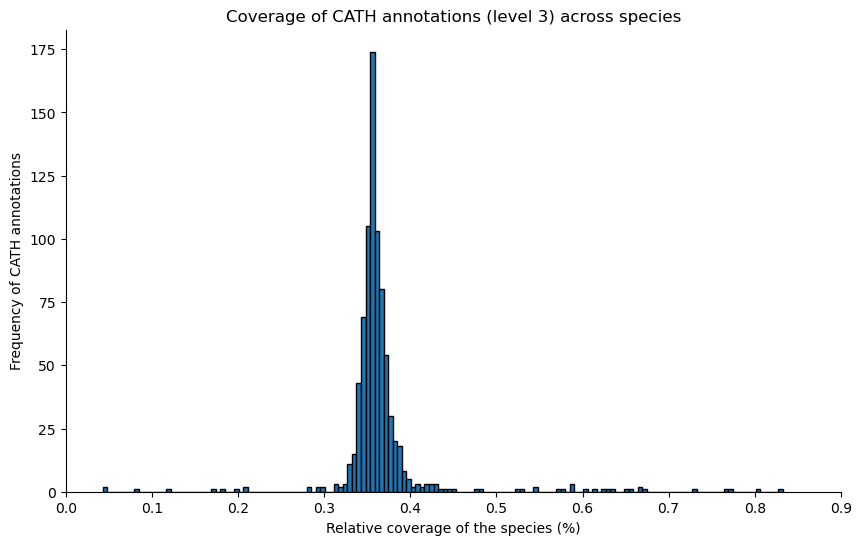

In [44]:
# Plot distribution of sequences count
plt.figure(figsize=(10, 6))
# Create a histogram
plt.hist(relative_coverage, bins=150, edgecolor='black')

plt.title('Coverage of CATH annotations (level 3) across species')
plt.xlabel('Relative coverage of the species (%)')
plt.ylabel('Frequency of CATH annotations')

plt.xticks(np.arange(0, 1, 0.1))

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.show()

In [46]:
np.mean(relative_coverage)

np.float64(0.36551616915422885)